In [1]:
import matplotlib
import warnings
import re
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler

%matplotlib inline
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size':16})
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

### 任务1. 项目背景

#### 1.1 项目背景与挖掘目标

In [2]:
#查看会员信息表
df_cum=pd.read_excel('./data/cumcm2018c1.xlsx')
df_cum.head()

,会员卡号,出生日期,性别,登记时间
0,c68b20b4,2002-11-02 00:00:00,0.0,2013-05-11 00:00:00.000
1,1ca15332,NaN,0.0,2004-11-04 16:31:52.436
2,a37cc182,1967-02-17 00:00:00,0.0,2004-12-31 21:24:34.216
3,2ab88539,1982-06-01 00:00:00,0.0,2010-11-19 00:00:00.000
4,b4c77269,1964-02-05 00:00:00,0.0,2007-12-14 00:00:00.000


In [3]:
#查看销售流水表
df_sale=pd.read_csv('./data/cumcm2018c2.csv',encoding='utf8')
df_sale.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,收银机号,单据号,柜组编码,柜组名称
0,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,290.0,270.20,兰芝化妆品正价瓶,270.20,6,25bb,8077.0,兰芝柜
1,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,325.0,302.80,兰芝化妆品正价瓶,302.80,6,25bb,8077.0,兰芝柜
2,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,195.0,181.80,兰芝化妆品正价瓶,181.80,6,25bb,8077.0,兰芝柜
3,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,270.0,251.55,兰芝化妆品正价瓶,251.55,6,25bb,8077.0,兰芝柜
4,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,2,245.0,456.55,兰芝化妆品正价瓶,456.55,6,25bb,8077.0,兰芝柜


### 2. 数据探索与预处理

#### 2.1 结合业务对数据进行探索和预处理

- 会员信息表数据探索与预处理

In [6]:
#先对会员信息表进行分析
df_cum.shape




(194760, 4)

In [7]:
df_cum.isnull().sum()

会员卡号        0
出生日期    34188
性别       9435
登记时间    12684
dtype: int64

In [10]:
df_cum['会员卡号'].nunique()

194754

从上面可以看出来，数据中会员卡号存在6个重复值，且会员登记时间缺失值占有1/20，需要去重去缺失值，可以采用众数来填充性别的缺失值

- 会员信息表去重

In [11]:
df_cum.drop_duplicates('会员卡号',inplace=True)
print('会员卡号去重后有{}条记录'.format(len(df_cum.会员卡号.unique())))

会员卡号去重后有194754条记录


- 去除等级时间的缺失值

In [15]:
df_cum.dropna(subset=['登记时间'],inplace=True)
df_cum.shape

(182070, 4)

- 性别采用众数填充

In [17]:
df_cum['性别'].fillna(df_cum['性别'].mode().values[0],inplace=True)
df_cum.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182070 entries, 0 to 194759
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   会员卡号    182070 non-null  object        
 1   出生日期    154474 non-null  object        
 2   性别      182070 non-null  float64       
 3   登记时间    182070 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 6.9+ MB


- 检测是否在登记时间这一字段存在异常值

In [19]:
df=df_cum['登记时间'] + pd.Timedelta(days=1)
df

0        2013-05-12 00:00:00.000
1        2004-11-05 16:31:52.436
2        2005-01-01 21:24:34.216
3        2010-11-20 00:00:00.000
4        2007-12-15 00:00:00.000
                   ...          
194754   2013-10-30 00:00:00.000
194756   2013-08-31 00:00:00.000
194757   2014-03-19 00:00:00.000
194758   2015-03-11 00:00:00.000
194759   2010-08-10 00:00:00.000
Name: 登记时间, Length: 182070, dtype: datetime64[ns]

In [20]:
df_cum.isnull().sum()

会员卡号        0
出生日期    27596
性别          0
登记时间        0
dtype: int64

In [23]:
#由于出生日期缺失值比较多，故新创建一个数据集L保存出生日期和性别信息
L=pd.DataFrame(df_cum.loc[df_cum['出生日期'].notnull(),['出生日期','性别']])
L['年龄']=L['出生日期'].astype(str).apply(lambda x:x[:3]+'0')
L.drop('出生日期',axis=1,inplace=True)
L['年龄'].value_counts()

1980    47142
1970    43407
1960    26678
1750    16748
1990    11811
1950     7078
1940      893
2010      370
2000      139
1930      110
1920       32
1900       21
1910        8
1880        4
1890        3
1860        3
5220        2
1870        2
1760        2
1850        2
9790        1
1790        1
2640        1
1780        1
8500        1
8900        1
7710        1
5190        1
9740        1
1770        1
5010        1
2190        1
9820        1
9880        1
1820        1
8400        1
8700        1
9690        1
6200        1
Name: 年龄, dtype: int64

- 可以发现年龄这一列差异值较多，将超出范围的年龄行删除

In [24]:
L['年龄']=L['年龄'].astype(int)
condition ='年龄 >=1920 and 年龄 <= 2020'
L=L.query(condition)
L.index=range(L.shape[0])
L['年龄'].value_counts()

1980    47142
1970    43407
1960    26678
1990    11811
1950     7078
1940      893
2010      370
2000      139
1930      110
1920       32
Name: 年龄, dtype: int64

- 因为出生日期不仅缺失值多，而且容易出错，且意义不大 将这列删除

In [25]:
df_cum.drop('出生日期',axis=1,inplace=True)
df_cum.index=range(df_cum.shape[0])
df_cum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182070 entries, 0 to 182069
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   会员卡号    182070 non-null  object        
 1   性别      182070 non-null  float64       
 2   登记时间    182070 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 4.2+ MB


In [26]:
df_cum.head()

,会员卡号,性别,登记时间
0,c68b20b4,0.0,2013-05-11 00:00:00.000
1,1ca15332,0.0,2004-11-04 16:31:52.436
2,a37cc182,0.0,2004-12-31 21:24:34.216
3,2ab88539,0.0,2010-11-19 00:00:00.000
4,b4c77269,0.0,2007-12-14 00:00:00.000


#### 销售流水表数据探索和预处理

In [29]:
df_sale.columns

Index(['会员卡号', '消费产生的时间', '商品编码', '销售数量', '商品售价', '消费金额', '商品名称', '此次消费的会员积分',
       '收银机号', '单据号', '柜组编码', '柜组名称'],
      dtype='object')

In [30]:
df_sale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1893532 entries, 0 to 1893531
Data columns (total 12 columns):
 #   Column     Dtype  
---  ------     -----  
 0   会员卡号       object 
 1   消费产生的时间    object 
 2   商品编码       object 
 3   销售数量       int64  
 4   商品售价       float64
 5   消费金额       float64
 6   商品名称       object 
 7   此次消费的会员积分  float64
 8   收银机号       int64  
 9   单据号        object 
 10  柜组编码       float64
 11  柜组名称       object 
dtypes: float64(4), int64(2), object(6)
memory usage: 173.4+ MB


- 确保销售流水数据表是唯一值，即销售数量以及销售金额不能为0

In [31]:
assert len(df_sale['销售数量']>0)==df_sale.shape[0]
assert len(df_sale['消费金额']>0)==df_sale.shape[0]

In [32]:
df_sale.isnull().sum()

会员卡号         1017486
消费产生的时间            0
商品编码               0
销售数量               0
商品售价               0
消费金额               0
商品名称               0
此次消费的会员积分    1017486
收银机号               0
单据号                0
柜组编码         1017486
柜组名称         1036956
dtype: int64

In [34]:
df_sale.isnull().mean()

会员卡号         0.537348
消费产生的时间      0.000000
商品编码         0.000000
销售数量         0.000000
商品售价         0.000000
消费金额         0.000000
商品名称         0.000000
此次消费的会员积分    0.537348
收银机号         0.000000
单据号          0.000000
柜组编码         0.537348
柜组名称         0.547631
dtype: float64

- 由于会员信息表和销售流水表唯一关联字段为会员卡号，所以缺失值直接删除

In [36]:
df_sale_clearn=df_sale.dropna(subset=['会员卡号'])
df_sale_clearn.isnull().sum()

会员卡号             0
消费产生的时间          0
商品编码             0
销售数量             0
商品售价             0
消费金额             0
商品名称             0
此次消费的会员积分        0
收银机号             0
单据号              0
柜组编码             0
柜组名称         19470
dtype: int64

- 可以看出只剩少量数据缺失，可以直接删掉对本项目无意义的字段

In [38]:
df_sale_clearn.drop(['收银机号','柜组编码','柜组名称'],axis=1,inplace=True)
#重置索引
df_sale_clearn.index=range(df_sale_clearn.shape[0])

In [39]:
type(df_sale_clearn)==type(df_cum)

True

In [40]:
df_sale_clearn.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号
0,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,290.0,270.20,兰芝化妆品正价瓶,270.20,25bb
1,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,325.0,302.80,兰芝化妆品正价瓶,302.80,25bb
2,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,195.0,181.80,兰芝化妆品正价瓶,181.80,25bb
3,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,270.0,251.55,兰芝化妆品正价瓶,251.55,25bb
4,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,2,245.0,456.55,兰芝化妆品正价瓶,456.55,25bb


#### 2.2 将会员信息表与销售流水表关联并合并

In [41]:
#按照卡号将两张表的信息进行合并，使用左连接合并
df=pd.merge(df_sale_clearn,df_cum,on='会员卡号',how='left')
df.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间
0,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,290.0,270.20,兰芝化妆品正价瓶,270.20,25bb,NaN,NaT
1,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,325.0,302.80,兰芝化妆品正价瓶,302.80,25bb,NaN,NaT
2,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,195.0,181.80,兰芝化妆品正价瓶,181.80,25bb,NaN,NaT
3,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,270.0,251.55,兰芝化妆品正价瓶,251.55,25bb,NaN,NaT
4,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,2,245.0,456.55,兰芝化妆品正价瓶,456.55,25bb,NaN,NaT


In [43]:
df.shape

(876046, 11)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876046 entries, 0 to 876045
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   会员卡号       876046 non-null  object        
 1   消费产生的时间    876046 non-null  object        
 2   商品编码       876046 non-null  object        
 3   销售数量       876046 non-null  int64         
 4   商品售价       876046 non-null  float64       
 5   消费金额       876046 non-null  float64       
 6   商品名称       876046 non-null  object        
 7   此次消费的会员积分  876046 non-null  float64       
 8   单据号        876046 non-null  object        
 9   性别         474446 non-null  float64       
 10  登记时间       474446 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 80.2+ MB


In [48]:
#这里再次查看消费金额>0，积分>0，消费数量>0
index1=df['消费金额']>0
index2=df['此次消费的会员积分']>0
index3=df['销售数量']>0
df1=df.loc[index1 & index3 &index2,:]
df1.index=range(df1.shape[0])
df1.shape

(738462, 11)

- 这里可以看到,merge之后数据异常值突然变多了，这里需要对此进行数据预处理，筛选出异常值，方便进行后续的分析

In [49]:
df1.isnull().sum()

会员卡号              0
消费产生的时间           0
商品编码              0
销售数量              0
商品售价              0
消费金额              0
商品名称              0
此次消费的会员积分         0
单据号               0
性别           344980
登记时间         344980
dtype: int64

In [51]:
#创建一个特征字段，判断是否为会员，1表示是会员，0表示不为会员
df1['会员']=1
df1.loc[df1['性别'].isnull(),'会员']=0
df1.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,会员
0,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,290.0,270.20,兰芝化妆品正价瓶,270.20,25bb,NaN,NaT,0
1,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,325.0,302.80,兰芝化妆品正价瓶,302.80,25bb,NaN,NaT,0
2,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,195.0,181.80,兰芝化妆品正价瓶,181.80,25bb,NaN,NaT,0
3,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,1,270.0,251.55,兰芝化妆品正价瓶,251.55,25bb,NaN,NaT,0
4,1be1e3fe,2015-01-01 00:05:41.593,f09c9303,2,245.0,456.55,兰芝化妆品正价瓶,456.55,25bb,NaN,NaT,0


### 任务3 统计分析

#### 3.1 分析会员的年龄构成，男女比例等基本信息

In [52]:
#处理男女比例这一列，女表示0，男表示1
L['性别']=L['性别'].apply(lambda x:'男' if x==1 else '女')

In [53]:
L.head()

,性别,年龄
0,女,2000
1,女,1960
2,女,1980
3,女,1960
4,男,1960


In [54]:
sex_sort=L['性别'].value_counts()
sex_sort

女    108283
男     29377
Name: 性别, dtype: int64

In [55]:
#可以将年龄划分为老年(1920-1950) 中年(1960-1990) 青年 (1990-2010)
L['年龄段']='中年'
L.loc[L['年龄']<=1950,'年龄段']='老年'
L.loc[L['年龄']>=1990,'年龄段']='青年'
res=L['年龄段'].value_counts()

In [56]:
res

中年    117227
青年     12320
老年      8113
Name: 年龄段, dtype: int64

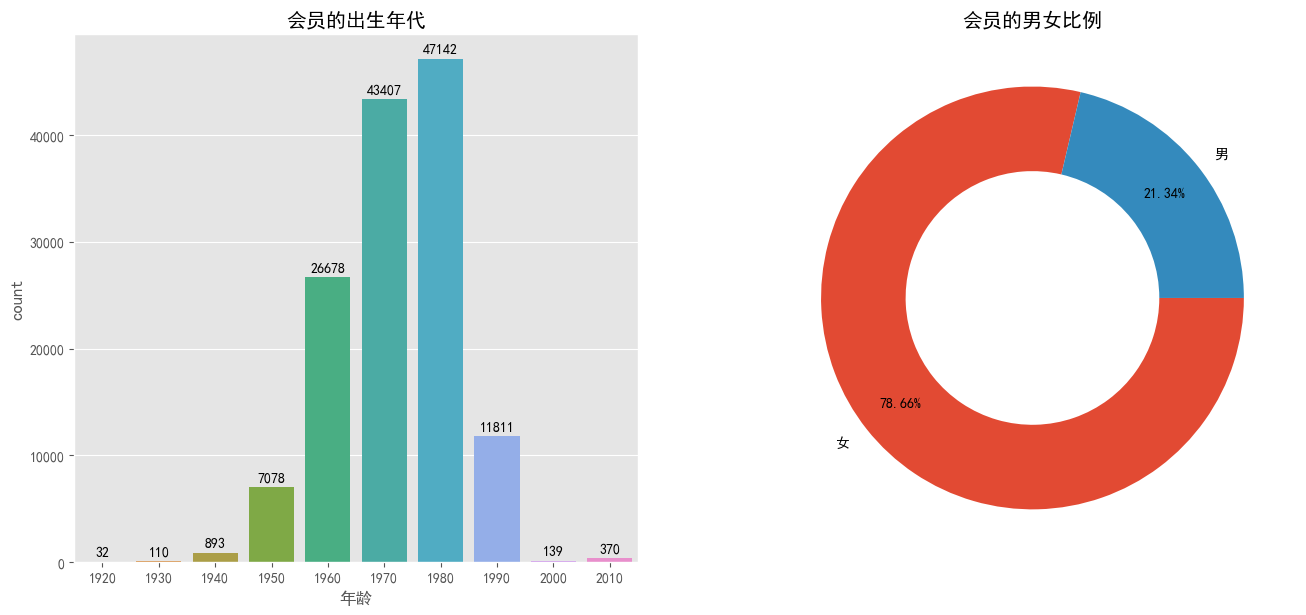

In [58]:
#使用上述处理后的数据集L，包含两个字段，分别是年龄和性别，先画出年龄的条形图
fig,axs=plt.subplots(1,2,figsize=(16,7),dpi=100)
#绘制条形图
ax=sns.countplot(x='年龄',data=L,ax=axs[0])
#设置数字标签
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2),y=height+500,s='{:.0f}'.format(height),ha='center')
axs[0].set_title('会员的出生年代')
#绘制饼图
axs[1].pie(sex_sort,labels=sex_sort.index,wedgeprops={'width':0.4},counterclock=False,autopct='%.2f%%',pctdistance=0.8)
axs[1].set_title('会员的男女比例')
plt.savefig('./百货商场会员出生年代及男女比例情况.png')

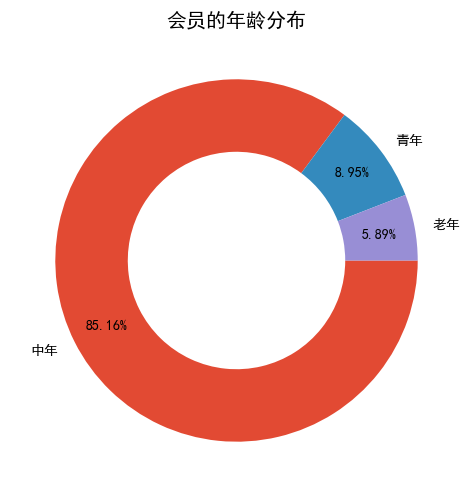

In [60]:
#绘制各个年龄段的饼图
plt.figure(figsize=(8,6),dpi=100)
plt.pie(res.values,labels=res.index,autopct='%.2f%%',pctdistance=0.8,
       counterclock=False,wedgeprops={'width':0.4})
plt.title('会员的年龄分布')
plt.savefig('./百货商场会员的年龄分布.png')

#### 任务3.2 分析会员的总订单占比，总消费金额占比等消费情况


In [64]:
df1.消费产生的时间.nunique()

400477

In [65]:
df1.单据号.nunique()

480

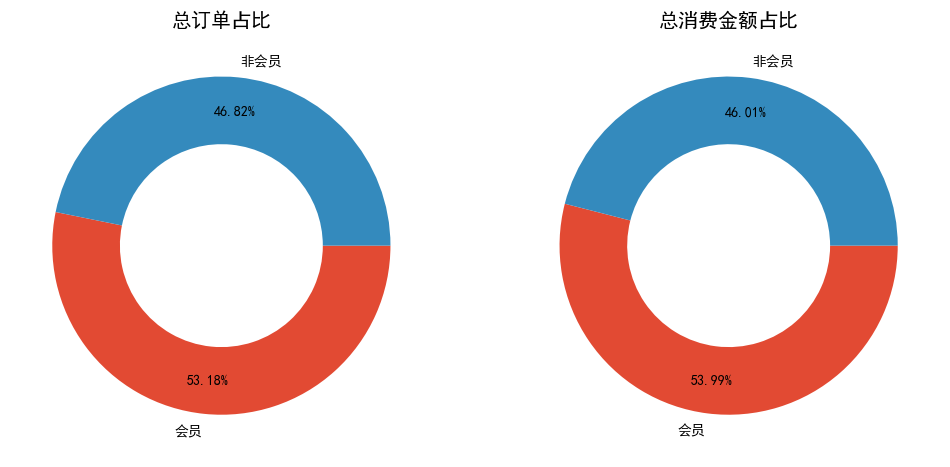

In [66]:
#由于相同的单据号可能不是同一笔消费,以消费产生的时间为分组依据
fig,axs=plt.subplots(1,2,figsize=(12,7),dpi=100)
axs[0].pie([len(df1.loc[df1['会员']==1,'消费产生的时间'].unique()),len(df1.loc[df1['会员']==0,'消费产生的时间'].unique())],
          labels=['会员','非会员'],wedgeprops={'width':0.4},counterclock=False,autopct='%.2f%%',pctdistance=0.8)
axs[0].set_title('总订单占比')
axs[1].pie([df1.loc[df1['会员']==1,'消费金额'].sum(),df1.loc[df1['会员']==0,'消费金额'].sum()],
          labels=['会员','非会员'],wedgeprops={'width':0.4},counterclock=False,autopct='%.2f%%',pctdistance=0.8)
axs[1].set_title('总消费金额占比')
plt.savefig('./百货商场总订单和总消费占比情况.png')

#### 任务3.3 分别以季度和天为单位，分析不同时间段会员的消费时间偏好

- 消费频次越高的用户粘性相对比较大

In [67]:
#将会员的消费数据另存为一个数据集
df_vip=df1.dropna()
df_vip.drop(['会员'],axis=1,inplace=True)
df_vip.index=range(df_vip.shape[0])
df_vip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393482 entries, 0 to 393481
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   会员卡号       393482 non-null  object        
 1   消费产生的时间    393482 non-null  object        
 2   商品编码       393482 non-null  object        
 3   销售数量       393482 non-null  int64         
 4   商品售价       393482 non-null  float64       
 5   消费金额       393482 non-null  float64       
 6   商品名称       393482 non-null  object        
 7   此次消费的会员积分  393482 non-null  float64       
 8   单据号        393482 non-null  object        
 9   性别         393482 non-null  float64       
 10  登记时间       393482 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1), object(5)
memory usage: 33.0+ MB


In [68]:
#将消费产生的时间转变为日期格式
df_vip['消费产生的时间']=pd.to_datetime(df_vip['消费产生的时间'])
#新增四列数据
df_vip['年份']=df_vip['消费产生的时间'].dt.year
df_vip['季度']=df_vip['消费产生的时间'].dt.quarter
df_vip['月份']=df_vip['消费产生的时间'].dt.month
df_vip['天']=df_vip['消费产生的时间'].dt.day
df_vip.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,年份,季度,月份,天
0,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1760.0,1760.0,MARYLINGC件,1678.82,5858,0.0,2007-08-12,2015,1,1,1
1,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,9072.0,9072.0,MARYLINGC件,8653.56,5858,0.0,2007-08-12,2015,1,1,1
2,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,1507.0,1507.0,汤普葛罗女鞋活动促销双,1437.49,5858,0.0,2007-08-12,2015,1,1,1
3,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,899.0,899.0,汤普葛罗女鞋活动促销双,857.54,5858,0.0,2007-08-12,2015,1,1,1
4,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1960.0,1960.0,MARYLINGC件,1869.59,5858,0.0,2007-08-12,2015,1,1,1


In [69]:
#定义一个函数来计算2015-2018在指定实践段的消费订单均数
def orders(df,label,div):
    x_list=np.sort(df[label].unique().tolist())
    order_nums=[]
    for i in range(len(x_list)):
        order_nums.append(int(len(df.loc[df[label]==x_list[i],'消费产生的时间'].unique())/div))
    return x_list,order_nums


{title[i]最优的时间为:{time_list[i][maxindex_list[i]]}	 对应的均值消费订单数为:{order_list[i]}}
{title[i]最优的时间为:{time_list[i][maxindex_list[i]]}	 对应的均值消费订单数为:{order_list[i]}}


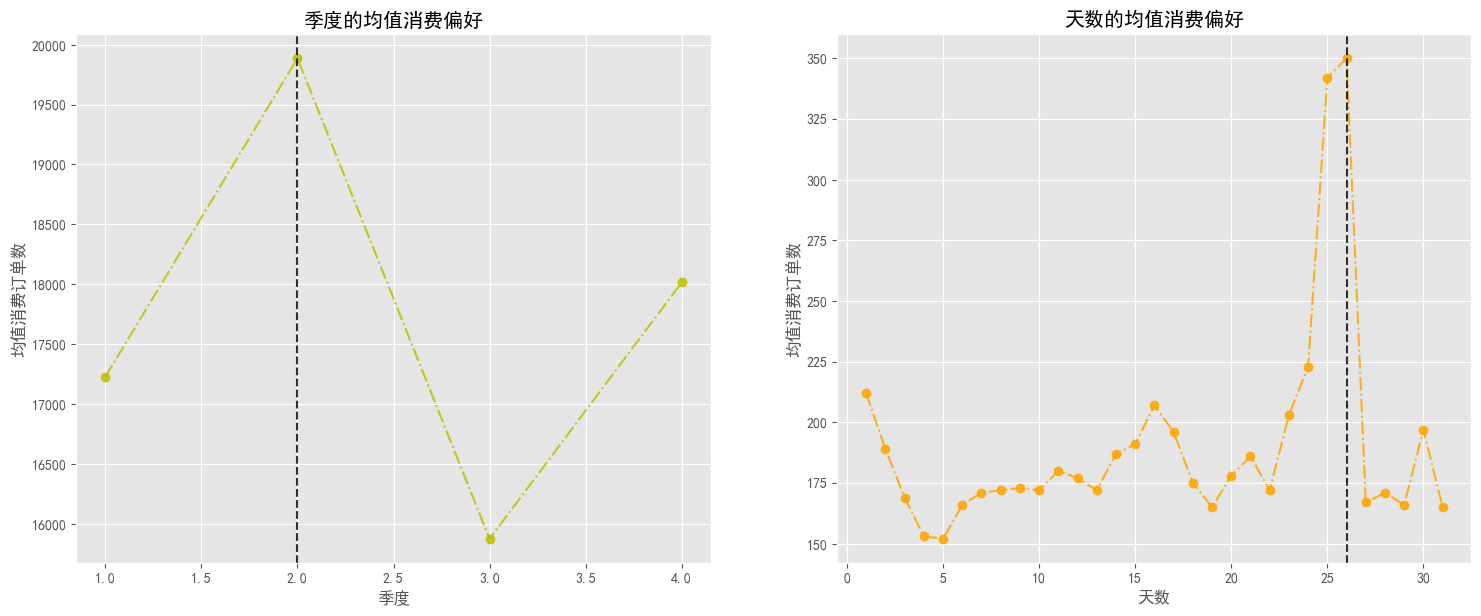

In [72]:
#前提假设：2015-2018年之间，消费者偏好在时间上不会发生太大的变化
quarters_list,quarters_order=orders(df_vip,'季度',3)
days_list,days_order=orders(df_vip,'天',36)
time_list=[quarters_list,days_list]
order_list=[quarters_order,days_order]
maxindex_list=[quarters_order.index(max(quarters_order)),days_order.index(max(days_order))]
fig,axs=plt.subplots(1,2,figsize=(18,7),dpi=100)
colors=np.random.choice(['r','g','b','orange','y'],replace=False,size=len(axs))
titles=['季度的均值消费偏好','天数的均值消费偏好']
labels=['季度','天数']
for i in range(len(axs)):
    ax=axs[i]
    ax.plot(time_list[i],order_list[i],linestyle='-.',c=colors[i],marker='o',alpha=0.85)
    ax.axvline(x=time_list[i][maxindex_list[i]],linestyle='--',c='k',alpha=0.8)
    ax.set_title(titles[i])
    ax.set_xlabel(labels[i])
    ax.set_ylabel('均值消费订单数')
    print(f"{title[i]最优的时间为:{time_list[i][maxindex_list[i]]}\t 对应的均值消费订单数为:{order_list[i]}}")
plt.savefig('./百货商城季度和天数的均值消费偏好情况.png')

In [77]:
#自定义函数来绘制不同年份之间的季度或天数的消费订单差异
def plot_qd(df,label_y,label_m,nrow,ncol):
    #必须去掉最后一年的数据,只能对2015-2017之间的数据进行分析
    y_list=np.sort(df[label_y].unique().tolist())[:-1]
    colors=np.random.choice(['r','g','b','orange','y','k','c','m'],replace=False,size=len(y_list))
    markers=['o','^', 'v']
    plt.figure(figsize=(8,6),dpi=100)
    fig,axs=plt.subplots(nrow,ncol,figsize=(16,7),dpi=100)
    for k in range(len(label_m)):
        m_list=np.sort(df[label_m[k]].unique().tolist())
        for i in range(len(y_list)):
            order_m=[]
            index1=df[label_y]==y_list[i]
            for j in range(len(m_list)):
                index2 = df[label_m[k]] == m_list[j]
                order_m.append(len(df.loc[index1 & index2, '消费产生的时间'].unique()))
            axs[k].plot(m_list, order_m, linestyle ='-.', c = colors[i], alpha = 0.8, marker = markers[i], label = y_list[i], markersize = 4)
        axs[k].set_xlabel(f'{label_m[k]}')
        axs[k].set_ylabel('消费订单数')
        axs[k].set_title(f'2015-2018年会员的{label_m[k]}消费订单差异')
        axs[k].legend()
    plt.savefig(f'./百货商城2015-2018年会员的{"和".join(label_m)}消费订单差异.png')

<Figure size 800x600 with 0 Axes>

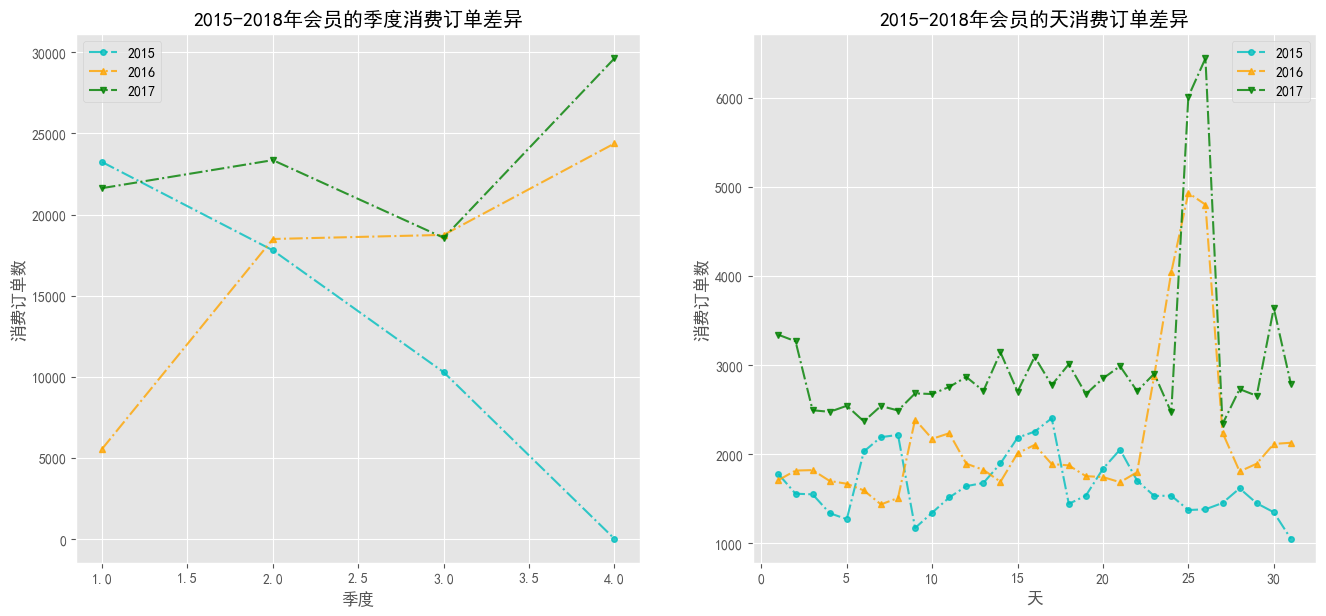

In [78]:
plot_qd(df_vip,'年份',['季度','天'],1,2)

In [82]:
#自定义函数来绘制不同年份之间的月份消费订单差异
def plot_ym(df,label_y,label_m):
    y_list=np.sort(df[label_y].unique().tolist())[:-1]
    m_list=np.sort(df[label_m].unique().tolist())
    colors = np.random.choice(['r', 'g', 'b', 'orange', 'y'], replace = False, size = len(y_list))
    markers = ['o', '^', 'v']
    fig,axs=plt.subplots(1,2,figsize=(18,8),dpi=100)
    for i in range(len(y_list)):
        order_m=[]
        money_m=[]
        index1=df[label_y]==y_list[i]
        for j in range(len(m_list)):
            index2=df[label_m]==m_list[j]
            order_m.append(len(df.loc[index1 & index2,'消费产生的时间'].unique()))
            money_m.append(df.loc[index1 & index2,'消费金额'].sum())
        axs[0].plot(m_list,order_m,linestyle='-.',c=colors[i],alpha=0.8,marker=markers[i],label=y_list[i])
        axs[1].plot(m_list,money_m,linestyle='-.',c=colors[i],alpha=0.8,marker=markers[i],label=y_list[i])
        axs[0].set_xlabel('月份')
        axs[0].set_ylabel('消费订单数')
        axs[0].set_title('2015-2018年会员的消费订单差异')
        axs[1].set_xlabel('月份')
        axs[1].set_ylabel('消费金额总数')
        axs[1].set_title('2015-2018年会员的消费金额差异')
        axs[0].legend()
        axs[1].legend()
    plt.savefig('./百货商场2015-2018年会员的消费订单和金额差异.png')

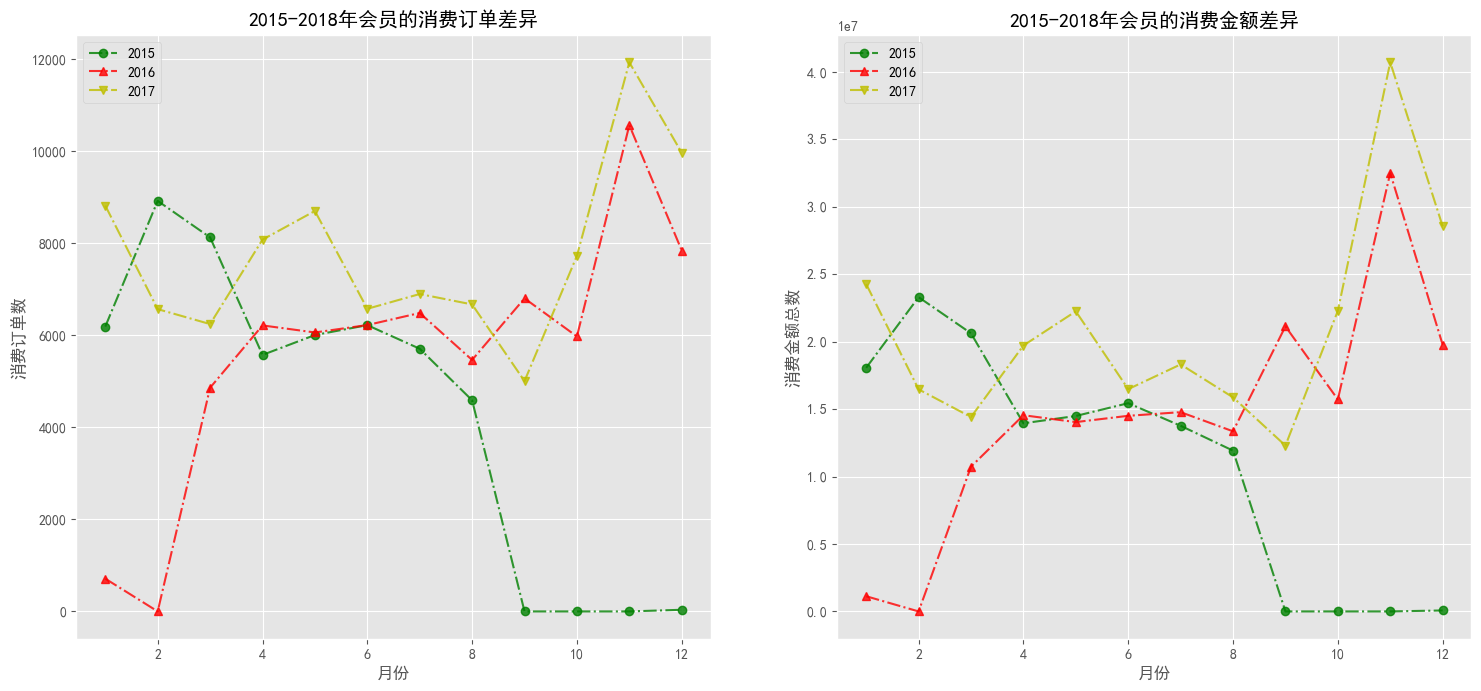

In [83]:
plot_ym(df_vip,'年份','月份')

- 再来分析下时间上的差异值

In [85]:
df_vip['时间']=df_vip['消费产生的时间'].dt.hour
df_vip.tail()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,年份,季度,月份,天,时间
393477,826ea280,2018-01-03 21:25:16.236,2c276195,1,299.0,299.0,芭芭麻麻正价件,299.0,fcd0,0.0,2017-12-25 19:30:50.746,2018,1,1,3,21
393478,826ea280,2018-01-03 21:25:16.236,2c276195,1,399.0,399.0,芭芭麻麻正价件,399.0,fcd0,0.0,2017-12-25 19:30:50.746,2018,1,1,3,21
393479,5d761c48,2018-01-03 21:27:28.686,a1e1cc27,1,990.0,990.0,Gucci品牌 正价无,990.0,1f26,0.0,2016-11-25 15:09:06.323,2018,1,1,3,21
393480,607c7cde,2018-01-03 21:38:15.343,3bc576f1,2,480.0,960.0,植村秀腮红刷20,960.0,3d84,0.0,2017-09-02 19:44:50.123,2018,1,1,3,21
393481,607c7cde,2018-01-03 21:38:15.343,c483e08b,1,200.0,200.0,植村秀眉笔4g,200.0,3d84,0.0,2017-09-02 19:44:50.123,2018,1,1,3,21


In [87]:
x_list,order_nums=orders(df_vip,'时间',1)

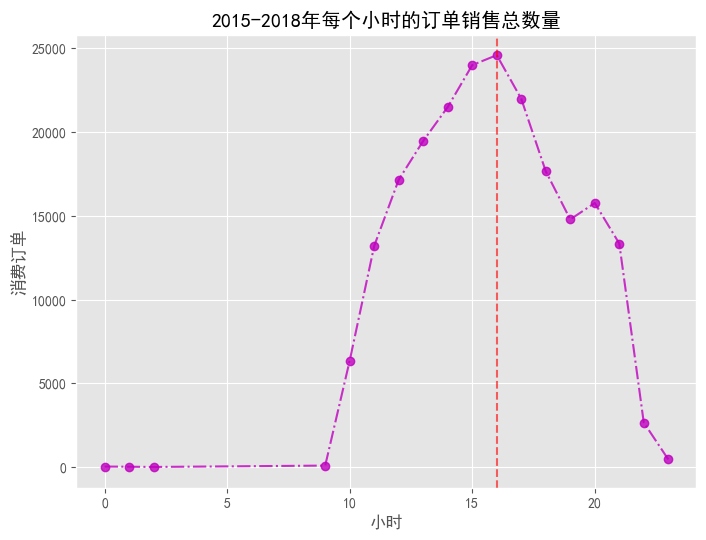

In [88]:
maxindex=order_nums.index(max(order_nums))
plt.figure(figsize=(8,6),dpi=100)
plt.plot(x_list,order_nums,linestyle='-.',marker='o',c='m',alpha=0.8)
plt.xlabel('小时')
plt.ylabel('消费订单')
plt.axvline(x=x_list[maxindex],linestyle='--',c='r',alpha=0.6)
plt.title('2015-2018年每个小时的订单销售总数量')
plt.savefig('./商场分析2015-2018年各段小时的销售订单数.png')

- 保存数据

In [91]:
df_vip.to_csv('./data/vip_info0221-1.csv',index=None)

### 任务4 会员用户画像和特征字段创造

#### 4.1构建会员用户基本特征标签

In [2]:
df_vip=pd.read_csv('./data/vip_info0221-1.csv')

In [3]:
df_vip.head()

,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,年份,季度,月份,天,时间
0,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1760.0,1760.0,MARYLINGC件,1678.82,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
1,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,9072.0,9072.0,MARYLINGC件,8653.56,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
2,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,1507.0,1507.0,汤普葛罗女鞋活动促销双,1437.49,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
3,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,899.0,899.0,汤普葛罗女鞋活动促销双,857.54,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0
4,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1960.0,1960.0,MARYLINGC件,1869.59,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0


In [4]:
#测试积分这一列有没有异常值
print(len(df_vip['此次消费的会员积分']>0)==df_vip.shape[0])
len(df_vip[df_vip['消费金额']>0])


True


393482

In [5]:
df_vip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393482 entries, 0 to 393481
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   会员卡号       393482 non-null  object 
 1   消费产生的时间    393482 non-null  object 
 2   商品编码       393482 non-null  object 
 3   销售数量       393482 non-null  int64  
 4   商品售价       393482 non-null  float64
 5   消费金额       393482 non-null  float64
 6   商品名称       393482 non-null  object 
 7   此次消费的会员积分  393482 non-null  float64
 8   单据号        393482 non-null  object 
 9   性别         393482 non-null  float64
 10  登记时间       393482 non-null  object 
 11  年份         393482 non-null  int64  
 12  季度         393482 non-null  int64  
 13  月份         393482 non-null  int64  
 14  天          393482 non-null  int64  
 15  时间         393482 non-null  int64  
dtypes: float64(4), int64(6), object(6)
memory usage: 48.0+ MB


- 筛选掉两列异常时间的数据

In [7]:
index1=df_vip['消费产生的时间']<'2018-01-03'
index2=df_vip['登记时间']<'2018-01-03'
df_vip=df_vip[index1 & index2]
df_vip.index=range(df_vip.shape[0])
df_vip.shape[0]

393006

In [8]:
df_vip['会员卡号'].nunique()

42548

- 说明每一个会员有多条消息记录


In [9]:
df_vip.columns

Index(['会员卡号', '消费产生的时间', '商品编码', '销售数量', '商品售价', '消费金额', '商品名称', '此次消费的会员积分',
       '单据号', '性别', '登记时间', '年份', '季度', '月份', '天', '时间'],
      dtype='object')

- 可以筛选出每一位会员，然后依据各个字段对其进行运算，求出对应的LRFMP

In [10]:
#自定义一个函数来实现两列数据时间相减
def time_minus(df,end_time):
    """
    df:为dateFrame形式，第一列为会员卡号，第二列为被减的时间
    end_time:结束时间
    """
    df.columns=['A','B']
    df['C']=end_time
    l=pd.to_datetime(df['C'])-pd.to_datetime(df['B'])
    l=l.apply(lambda x:str(x).split(' ')[0])
    l=l.astype(int)/30
    return l 

In [19]:
#开始登记的时间
df_L=df_vip.groupby('会员卡号')['登记时间'].agg(lambda x: x.values[-1]).reset_index()
#最后一次消费的时间
df_R=df_vip.groupby('会员卡号')['消费产生的时间'].agg(lambda x :x.values[-1]).reset_index()

In [24]:
#调用函数，end_time='2018-1-3'
end_time='2018-1-3'
L=time_minus(df_L,end_time)
R=time_minus(df_R,end_time)

ValueError: Length mismatch: Expected axis has 3 elements, new values have 2 elements

In [28]:
#会员消费的总次数
F=df_vip.groupby('会员卡号')['消费产生的时间'].agg(lambda x :len(np.unique(x.values))).reset_index(drop=True)


In [35]:
#会员消费的总金额
M=df_vip.groupby('会员卡号')['消费金额'].agg('sum').reset_index(drop=True)

In [36]:
#会员的积分总数
P=df_vip.groupby('会员卡号')['此次消费的会员积分'].agg('sum').reset_index(drop=True)

- 创建一列特征字段'消费时间偏好’
  - 凌晨 0-5
  - 上午 6-10
  - 中午 11-13
  - 下午 14-17
  - 晚上 18-23

In [39]:
df_vip['消费时间偏好']=df_vip['时间'].apply(lambda x: '晚上' if x>=18 else '下午' if x>=14 else '中午' if x>=11 else '上午' if x>=6 else '凌晨')
df_vip


,会员卡号,消费产生的时间,商品编码,销售数量,商品售价,消费金额,商品名称,此次消费的会员积分,单据号,性别,登记时间,年份,季度,月份,天,时间,消费时间偏好
0,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1760.0,1760.0,MARYLINGC件,1678.82,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
1,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,9072.0,9072.0,MARYLINGC件,8653.56,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
2,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,1507.0,1507.0,汤普葛罗女鞋活动促销双,1437.49,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
3,d8d36575,2015-01-01 00:06:38.313,50a2c4f5,1,899.0,899.0,汤普葛罗女鞋活动促销双,857.54,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
4,d8d36575,2015-01-01 00:06:38.313,d313ab1e,1,1960.0,1960.0,MARYLINGC件,1869.59,5858,0.0,2007-08-12 00:00:00.000,2015,1,1,1,0,凌晨
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393001,5f0f5718,2018-01-02 21:09:31.703,12b9a5b7,1,330.0,330.0,圣罗兰气垫粉底芯.,330.00,8c57,1.0,2016-07-17 00:00:00.000,2018,1,1,2,21,晚上
393002,88b2d3dd,2018-01-02 21:10:36.703,3993f69b,1,1080.0,80.0,兰蔻菁眼/大黑/美丽人生15ml,80.00,4bc8,0.0,2017-03-31 00:00:00.000,2018,1,1,2,21,晚上
393003,14bc144b,2018-01-02 21:19:51.703,6c453411,1,161.0,161.0,伊维斯正价件,161.00,fcd0,0.0,2015-03-04 00:00:00.000,2018,1,1,2,21,晚上
393004,cb750c7d,2018-01-02 21:24:44.783,38b3338a,1,310.0,310.0,阿玛尼丝绒/漆光唇釉.,310.00,4bc8,0.0,2017-12-14 00:00:00.000,2018,1,1,2,21,晚上


In [43]:
#会员消费的时间偏好，取众数
S=df_vip.groupby('会员卡号')['消费时间偏好'].agg(lambda x:x.mode().values[0]).reset_index(drop=True)


In [44]:
#会员性别
X=df_vip.groupby('会员卡号')['性别'].agg(lambda x: '女' if x.unique()[0]==0 else '男').reset_index(drop=True)

In [46]:
#开始构建对应的特征标签
df_i=pd.Series(df_vip['会员卡号'].unique())
df_LRFMPSX=pd.concat([df_i,L,R,F,M,P,S,X],axis=1)
df_LRFMPSX.columns=['id','L','R','F','M','P','S','X']
df_LRFMPSX.head()

,id,L,R,F,M,P,S,X
0,d8d36575,23.933333,13.433333,2,5266.5,5267.0,中午,女
1,8527d4d0,107.066667,2.066667,7,12850.0,11850.0,下午,女
2,586a3339,52.300000,0.566667,10,6340.8,6141.0,上午,女
3,c2477497,56.066667,2.266667,1,8964.0,8964.0,中午,女
4,0706d57c,18.200000,2.066667,1,236.0,236.0,上午,女


In [47]:
#保存数据
df_LRFMPSX.to_csv('./data/LRFMPSX.csv',index=None)

#### 构建会员用户业务特征标签


In [51]:
from wordcloud import WordCloud

ModuleNotFoundError: No module named 'wordcloud'

In [52]:
df=pd.read_csv('./data/LRFMPSX.csv')
df.head()

,id,L,R,F,M,P,S,X
0,d8d36575,23.933333,13.433333,2,5266.5,5267.0,中午,女
1,8527d4d0,107.066667,2.066667,7,12850.0,11850.0,下午,女
2,586a3339,52.300000,0.566667,10,6340.8,6141.0,上午,女
3,c2477497,56.066667,2.266667,1,8964.0,8964.0,中午,女
4,0706d57c,18.200000,2.066667,1,236.0,236.0,上午,女


In [53]:
df.shape

(42548, 8)

In [55]:
df.isnull().sum()

id    0
L     0
R     0
F     0
M     0
P     0
S     0
X     0
dtype: int64

In [56]:
df.describe()

,L,R,F,M,P
count,42548.000000,42548.000000,42548.000000,4.254800e+04,4.254800e+04
mean,43.272356,12.748108,5.000917,1.314873e+04,1.166768e+04
std,38.427058,11.415613,9.963993,3.650895e+04,3.293682e+04
min,0.000000,0.000000,1.000000,7.300000e-01,8.100000e-01
25%,11.966667,2.900000,1.000000,1.424820e+03,1.250000e+03
50%,32.133333,9.433333,2.000000,3.885000e+03,3.410000e+03
75%,67.200000,19.433333,5.000000,1.106000e+04,9.345000e+03
max,185.000000,36.566667,287.000000,1.511900e+06,1.413370e+06


- 开始对数据进行分组
  - L 入会成都：3一下为新用户，4-12为中等用户，13月以上为老用户
  - R 最近购买的时间
  - F 消费频次 ：次数20次以上为高频消费，6-19次为中频消费，5次以下为低频消费
  - M 消费金额 ： 10w以上为高消费，1-10w为中消费,1w下为低消费
  - P 消费积分 :  10w以上位高积分用户。。。。。。

In [57]:
df_profile=pd.DataFrame()
df_profile['会员卡号']=df['id']
df_profile['性别']=df['X']
df_profile['消费偏好']=df['S'].apply(lambda x:'您喜欢在'+str(x)+'进行消费')
df_profile['入会程度']=df['L'].apply(lambda x:'老用户' if int(x) >=13 else '中等用户' if int(x) >=4 else '新用户')
df_profile['最近购买的时间']=df['R'].apply(lambda x: '您最近'+str(int(x)*30)+'天前进行了购物')
df_profile['消费频次'] = df['F'].apply(lambda x: '高频消费' if x >= 20 else '中频消费' if x >= 6 else '低频消费')
df_profile['消费金额']=df['M'].apply(lambda x:'高消费用户' if int(x)>=1e+05 else '中消费用户' if int(x)>=1e+04 else '低消费用户')
df_profile['消费积分'] = df['P'].apply(lambda x: '高等积分用户' if int(x) >= 1e+05 else '中等积分用户' if int(x) >= 1e+04 else '低等积分用户')
df_profile

,会员卡号,性别,消费偏好,入会程度,最近购买的时间,消费频次,消费金额,消费积分
0,d8d36575,女,您喜欢在中午进行消费,老用户,您最近390天前进行了购物,低频消费,低消费用户,低等积分用户
1,8527d4d0,女,您喜欢在下午进行消费,老用户,您最近60天前进行了购物,中频消费,中消费用户,中等积分用户
2,586a3339,女,您喜欢在上午进行消费,老用户,您最近0天前进行了购物,中频消费,低消费用户,低等积分用户
3,c2477497,女,您喜欢在中午进行消费,老用户,您最近60天前进行了购物,低频消费,低消费用户,低等积分用户
4,0706d57c,女,您喜欢在上午进行消费,老用户,您最近60天前进行了购物,低频消费,低消费用户,低等积分用户
...,...,...,...,...,...,...,...,...
42543,406380bf,女,您喜欢在晚上进行消费,中等用户,您最近270天前进行了购物,低频消费,低消费用户,低等积分用户
42544,4f7fa021,女,您喜欢在晚上进行消费,新用户,您最近30天前进行了购物,低频消费,低消费用户,低等积分用户
42545,14a60aea,男,您喜欢在晚上进行消费,老用户,您最近570天前进行了购物,低频消费,低消费用户,低等积分用户
42546,139ddf73,女,您喜欢在下午进行消费,老用户,您最近330天前进行了购物,中频消费,中消费用户,中等积分用户


### 任务5 会员用户细分和营销方案指定

#### 5.1 会员用户的聚类分析及可视化

In [58]:
#先对数据进行标准化处理
df0=df.iloc[:,1:6]
res_std=StandardScaler().fit_transform(df0)

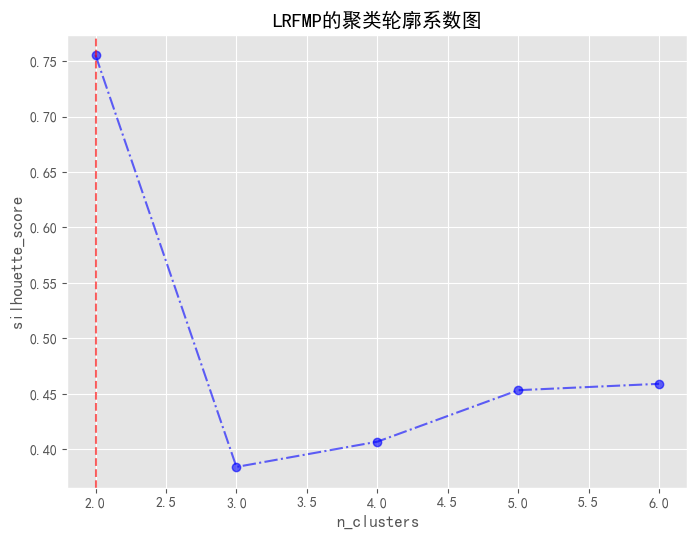

In [60]:
#对数据进行聚类
n_clusters=range(2,7)
scores=[]
for i in range(len(n_clusters)):
    clf=KMeans(n_clusters=n_clusters[i],random_state=20).fit(res_std)
    scores.append(silhouette_score(res_std,clf.labels_))
maxindex=scores.index(max(scores))
plt.figure(figsize=(8,6),dpi=100)
plt.plot(n_clusters,scores,linestyle='-.',c='b',alpha=0.6,marker='o')
plt.axvline(x=n_clusters[maxindex],linestyle='--',c='r',alpha=0.6)
plt.title('LRFMP的聚类轮廓系数图')
plt.ylabel('silhouette_score')
plt.xlabel('n_clusters')
plt.savefig('./百货商场LRFMP聚类轮廓系数图.png')

- 可以从轮廓系数看出，聚类数最佳为2，因此，我们使用聚类数为2 的标准化数据进行聚类，得到两类用户的LRFMP的均值数据，以此来判断两者之间的差异

#### 5.2对会员用户进行精细划分并分析不同的群体带来的价值差异

In [61]:
#以聚类为2贴上对应的标签
clf=KMeans(n_clusters=2,random_state=20).fit(res_std)
df0['labels']=clf.labels_
df0

,L,R,F,M,P,labels
0,23.933333,13.433333,2,5266.5,5267.0,1
1,107.066667,2.066667,7,12850.0,11850.0,1
2,52.300000,0.566667,10,6340.8,6141.0,1
3,56.066667,2.266667,1,8964.0,8964.0,1
4,18.200000,2.066667,1,236.0,236.0,1
...,...,...,...,...,...,...
42543,9.333333,9.333333,1,300.0,300.0,1
42544,1.166667,1.166667,1,5530.0,5530.0,1
42545,57.433333,19.700000,2,7139.0,7139.0,1
42546,80.966667,11.600000,12,11712.0,11712.0,1


In [62]:
df0['labels'].value_counts()

1    41554
0      994
Name: labels, dtype: int64

In [66]:
#用均值来计算两样本之间的LRFMP
L_avg=df0.groupby('labels').agg({'L':np.mean}).reset_index()
L_avg

,labels,L
0,0,40.725755
1,1,43.333272


In [65]:
R_avg=df0.groupby('labels').agg({'R':np.mean}).reset_index()
F_avg=df0.groupby('labels').agg({'F':np.mean}).reset_index()
M_avg=df0.groupby('labels').agg({'M':np.mean}).reset_index()
P_avg=df0.groupby('labels').agg({'P':np.mean}).reset_index()

In [71]:
#绘制相关的条形图
def plot_bar(df_list,nrow,ncol):
    fig,axs=plt.subplots(nrow,ncol,figsize=(2*(ncol+2),2.5),dpi=100)
    for i in range(len(axs)):
        ax=axs[i]
        df=df_list[i]
        ax.bar(df.iloc[:,0],df.iloc[:,1],color='b',alpha=0.4,width=0.5)
        for x,y in enumerate(df.iloc[:,1].tolist()):
            ax.text(x, y / 2, '%.0f' % y, va = 'bottom', ha = 'center', fontsize = 12)
        ax.set_xticks([0,1])
        ax.set_yticks(())
        ax.set_title(f'{df.columns[1]}')
    plt.suptitle('两类客户的LRFMP均值差异',y=1.1,fontsize=14)

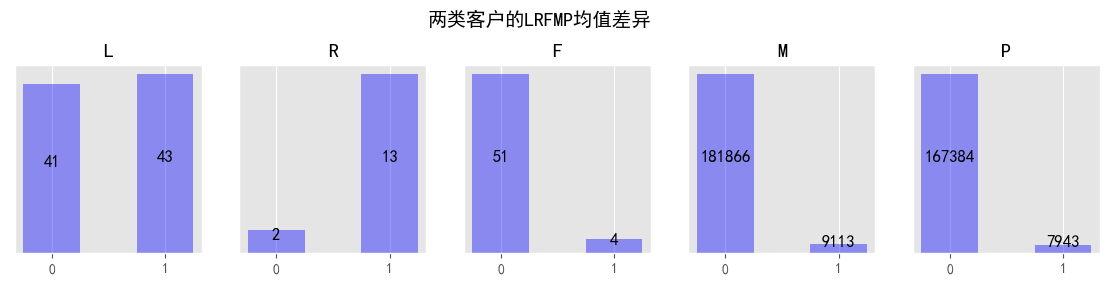

In [72]:
df_list=[L_avg,R_avg,F_avg,M_avg,P_avg]
plot_bar(df_list,1,5)

从上面可以看出来标签为0的客户消费频次，消费金额以及消费积分远远大于标签为1 的客户可以将这类用户定义为重要保持客户